# Visually Comparing Climate Models



---
### Summary

In this notebook, I will be comparing three climate reanalysis models:

* NCEP-DOE Reanalysis 2: Surface
* ERA5
* CMIP5

I will be looking at the following variables:

* Mean Sea Level Pressure (CMIP5, ERA5, NCEP)
* Surface Pressure (ERA5, NCEP)

I will be trying to user RBIG in order to assess how similar these models are. I'll be looking at the following IT measures. If these climate models are that similar, then they should exhibit similar IT measures.

---
### Preprocessing Steps

**Regridded Spatially**

* The ERA5 had the coarsest spatial resolution (2.5 x 2.5). 
* I regridded the NCEP from (0.25 x 0.25) to (2.5 x 2.5).
* I regridded the CMIP5 from (2 x 2.5) to (2.5 x 2.5).

**Temporal Resolution**

* ERA5 and NCEP go from 1980-2019
* CMIP5 goes from 2006-2018
* For comparing ERA5 vs CMIP5 and NCEP vs CMIPF, I found the same time components


---
### Measures

I'm measuring the following:

* Entropy - expected uncertainty
* Total Correlation - amount of redundant information between features
* Mutual Information - amount of information shared between variables


---
### Data

**Inputs**

I'm taking each year as is. Each spatial location is a sample and each year is a feature. My inputs are:

$$X \in \mathbb{R}^{\text{spatial } \times \text{ month}}$$

**Outputs**

All my information theory measures are in nats. They are scalars.

---
### Hypothesis

Simple: The ERA5 and the NCEP model should be more similar than the CMIP5 model compared to each of them. 

---
## Data - Climate Models

In [103]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../../../"
sys.path.insert(0, f'{source_path}')


# ESDC tools
sys.path.insert(0, f'/home/emmanuel/code/py_esdc')
# from esdc.preprocessing import normalize_temporal

import cdsapi
from zipfile import ZipFile
import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

# Visualization Tools
from src.data.climate.loader import ResultsLoader
from src.visualization.climate import PlotResults

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use(['seaborn-notebook', 'fivethirtyeight'])

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/raw/"
results_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/results/amip/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/"

## Results

### Entropy

In [450]:
results = pd.read_csv(results_path + 'individual_trial_v1' + '.csv', index_col=[0])
results.tail()


,base,cmip,h_base,h_cmip,spatial,subsample,t_base,t_cmip,tc_base,tc_cmip,variable
255,era5,noresm1_m,-78.583197,-96.304804,6.0,100000.0,730.347337,604.008909,122.510442,142.709660,psl
256,era5,noresm1_m,-107.833073,-134.372838,7.0,100000.0,1118.617290,1111.506056,167.527858,197.583696,psl
257,era5,noresm1_m,-137.749665,-168.512649,8.0,100000.0,2026.137733,426.119761,216.937718,252.734923,psl
258,era5,noresm1_m,-170.201952,-217.132902,9.0,100000.0,1012.726763,502.615962,269.756842,323.194951,psl
259,era5,noresm1_m,-211.135733,-270.725025,10.0,100000.0,919.196359,788.227240,332.253818,400.066240,psl


In [432]:
results[results['base'] == 'ncep']

,base,cmip,h_base,h_cmip,spatial,subsample,t_base,t_cmip,tc_base,tc_cmip,variable
0,ncep,inmcm4,1.148658,1.227094,1.0,100000.0,2.078117,2.191642,0.000000,0.000000,psl
1,ncep,inmcm4,-3.408737,-2.943323,2.0,100000.0,16.499979,19.820095,7.958095,7.806940,psl
2,ncep,inmcm4,-16.427491,-13.668522,3.0,100000.0,59.303242,63.809711,26.813447,24.739498,psl
3,ncep,inmcm4,-36.418436,-28.422482,4.0,100000.0,140.180021,156.601960,55.001804,48.044893,psl
4,ncep,inmcm4,-61.996087,-46.435779,5.0,100000.0,281.296864,258.948741,91.010718,77.109150,psl
...,...,...,...,...,...,...,...,...,...,...,...
245,ncep,noresm1_m,-94.735433,-88.460085,6.0,100000.0,656.799239,623.755287,135.884398,134.175803,psl
246,ncep,noresm1_m,-133.141635,-122.443681,7.0,100000.0,1124.606767,1178.170551,188.727237,184.085890,psl
247,ncep,noresm1_m,-172.826647,-156.336467,8.0,100000.0,501.970815,753.979842,246.930187,237.864519,psl
248,ncep,noresm1_m,-221.879859,-198.735011,9.0,100000.0,601.809308,657.819632,316.233458,302.173553,psl


In [451]:
def plot_global_entropy(results_df: pd.DataFrame, base: str, cmip: str, normalized=True, log_mi=True)-> None:
    
    if normalized == True:
        results_df['h_cmip'] = results_df['h_cmip'] / results_df['spatial']
        results_df['h_base'] = results_df['h_base'] / results_df['spatial']
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    sns.scatterplot(data=results_df, x='spatial', y='h_base', label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y='h_cmip', label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Entropy, H')
    plt.legend()
    plt.show()

#### Example

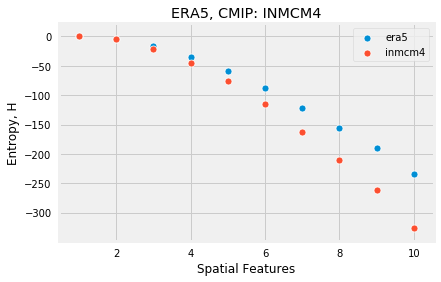

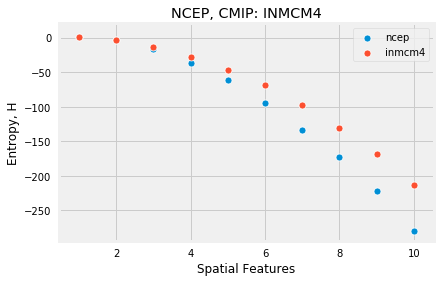

In [452]:
plot_global_entropy(results, 'era5', 'inmcm4', normalized=False,)
plot_global_entropy(results, 'ncep', 'inmcm4', normalized=False)

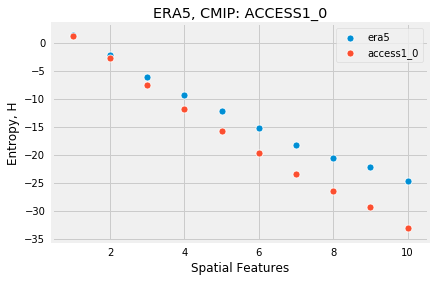

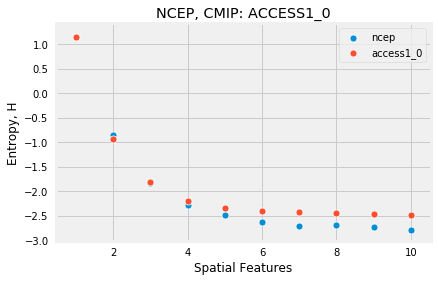

In [453]:
plot_global_entropy(results, 'era5', 'access1_0')
plot_global_entropy(results, 'ncep', 'access1_0')

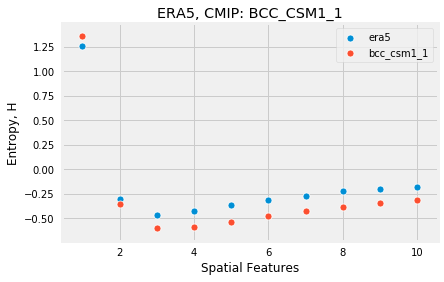

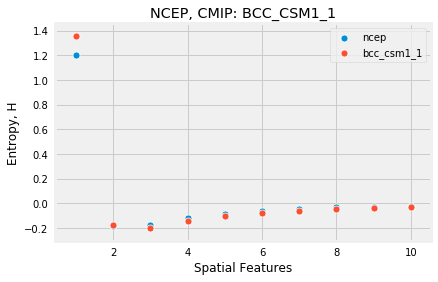

In [454]:
plot_global_entropy(results, 'era5', 'bcc_csm1_1')
plot_global_entropy(results, 'ncep', 'bcc_csm1_1')

### Difference in Entropy

In [458]:
import numpy as np

def plot_global_diff_entropy(results_df: pd.DataFrame, base: str, normalized=True, log_mi=False)-> None:
    
    
    results_copy = results_df[results_df['base'] == base]
    
    # calculate difference
    results_copy['h_diff'] = np.abs(results_copy['h_cmip'] - results_copy['h_base'])
        
    if normalized == True:
        results_copy['h_diff'] = results_copy['h_diff'] / results_copy['spatial']
    if log_mi == True:
        results_copy['h_diff'] = np.log(results_copy['h_diff'])
    
    fig, ax = plt.subplots()
#     sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='base', color='black')
    sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='cmip')
        
    plt.title(f'')
    plt.xlabel('Spatial Features')
    plt.ylabel('Entropy, H')
    plt.legend(ncol=2, bbox_to_anchor=(2.05, 1), fontsize=16)
#     plt.tight_layout()
    plt.show()

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


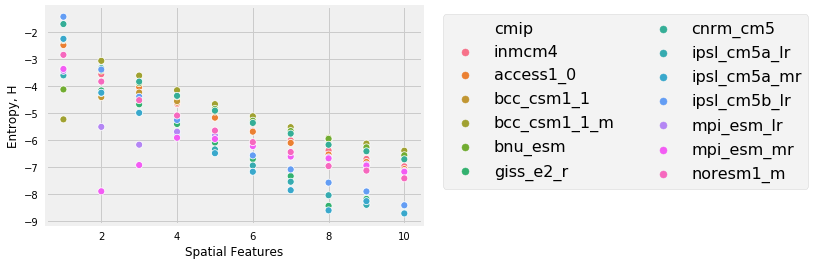

In [459]:
plot_global_diff_entropy(results, 'era5', log_mi=True)

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


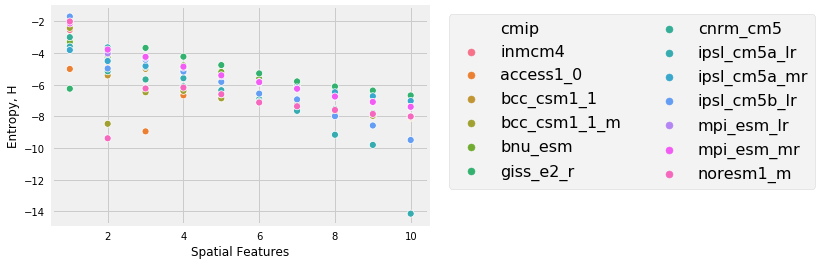

In [460]:
plot_global_diff_entropy(results, 'ncep', log_mi=True)

#### With Trials

In [396]:
results = pd.read_csv(results_path + 'global_individual_v2' + '.csv', index_col=[0])
results.tail()

,base,cmip,h_base,h_cmip,spatial,subsample,t_base,t_cmip,tc_base,tc_cmip,trial,variable
89,ncep,inmcm4,-220.538259,-166.638338,9.0,100000.0,1174.526437,1867.651477,317.228234,267.121006,9.0,psl
90,ncep,inmcm4,-277.052756,-211.970468,10.0,100000.0,1717.057910,2336.629872,395.865352,335.666700,0.0,psl
91,ncep,inmcm4,-275.549846,-210.910893,10.0,100000.0,1968.807951,2276.702278,394.918273,334.834671,1.0,psl
92,ncep,inmcm4,-277.499301,-213.713400,10.0,100000.0,2060.949339,2143.682440,396.731996,337.666523,2.0,psl
93,ncep,inmcm4,-276.466885,-209.351855,10.0,100000.0,2221.859382,2571.432894,396.014959,333.492110,3.0,psl


In [397]:
def plot_global_entropy(results_df: pd.DataFrame, base: str, cmip: str)-> None:
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    sns.scatterplot(data=results_df, x='spatial', y='h_base', label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y='h_cmip', label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Entropy, H')
    plt.legend()
    plt.show()

In [398]:

results_ = results[results['base'] == 'ncep']
results_ = results_[results_['cmip'] == 'inmcm4']
results_['h_cmip'] = results_['h_cmip'] / results_['spatial']
results_.groupby(['spatial']).mean()
# results_ = results_[results_['spatial'] == 1.0]
# results_.mean(['trial'])

,h_base,h_cmip,subsample,t_base,t_cmip,tc_base,tc_cmip,trial
spatial,,,,,,,,
1.0,1.224428,1.257564,100000.0,4.880306,5.055687,0.000000,0.000000,4.5
2.0,-3.159978,-1.407663,100000.0,36.307454,41.259031,8.046948,7.841133,4.5
3.0,-16.086698,-4.510076,100000.0,117.003894,148.383447,27.044349,24.816643,4.5
4.0,-35.805155,-7.072404,100000.0,297.077969,329.071862,55.207126,48.303781,4.5
5.0,-61.502536,-9.374444,100000.0,573.986261,599.289550,91.716900,78.066944,4.5
6.0,-93.592120,-11.518494,100000.0,1058.505055,979.109610,136.994526,114.027871,4.5
7.0,-131.411389,-13.809431,100000.0,1946.185962,1265.841815,190.200908,157.605942,4.5
8.0,-171.427330,-16.181556,100000.0,1319.384931,1400.563413,248.058008,208.899187,4.5
9.0,-220.728365,-18.649023,100000.0,1419.335022,1735.023644,317.505307,268.374341,4.5


In [399]:
results_.groupby(['spatial']).std()


,h_base,h_cmip,subsample,t_base,t_cmip,tc_base,tc_cmip,trial
spatial,,,,,,,,
1.0,0.002390,0.003478,0.0,0.055293,0.053158,0.000000,0.000000,3.027650
2.0,0.015347,0.011225,0.0,4.854833,7.598034,0.015847,0.023293,3.027650
3.0,0.048413,0.024436,0.0,10.976892,12.058410,0.060671,0.085688,3.027650
4.0,0.135151,0.045903,0.0,42.845213,45.976555,0.158689,0.176432,3.027650
5.0,0.278073,0.051730,0.0,44.083450,78.685699,0.326023,0.237519,3.027650
6.0,0.329846,0.094403,0.0,162.499521,139.304297,0.300363,0.537472,3.027650
7.0,0.958364,0.113917,0.0,421.557286,331.016762,1.005496,0.752068,3.027650
8.0,0.768170,0.083065,0.0,546.448645,193.019276,0.839584,0.618041,3.027650
9.0,0.405776,0.076667,0.0,257.823912,192.556246,0.497856,0.718718,3.027650


<ErrorbarContainer object of 3 artists>

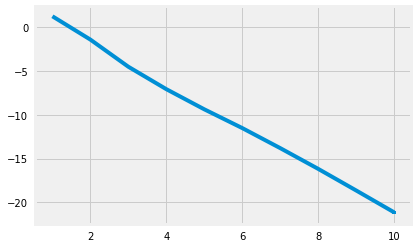

In [400]:
plt.errorbar(
    x=results_.groupby(['spatial']).mean().index, 
    y=results_.groupby(['spatial']).mean()['h_cmip'], 
    yerr=results_.groupby(['spatial']).std()['h_cmip']
)

### Total Correlation

In [402]:
def plot_global_tc(results_df: pd.DataFrame, base: str, cmip: str)-> None:
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    sns.scatterplot(data=results_df, x='spatial', y='tc_base', label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y='tc_cmip', label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Total Correlation, TC')
    plt.legend()
    plt.show()

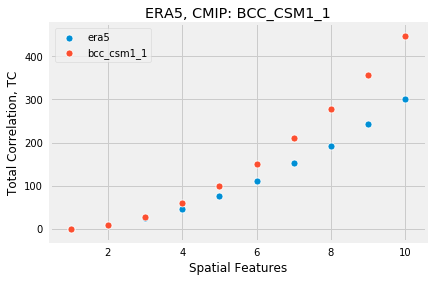

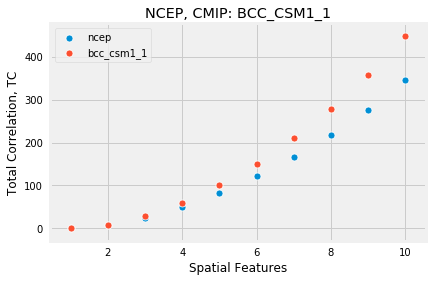

In [403]:
plot_global_tc(results, 'era5', 'bcc_csm1_1')
plot_global_tc(results, 'ncep', 'bcc_csm1_1')

In [404]:
def plot_global_diff_tc(results_df: pd.DataFrame, base: str, normalized=True)-> None:
    
    
    results_copy = results_df[results_df['base'] == base]
    
    # calculate difference
    results_copy['tc_diff'] = np.abs(results_copy['tc_cmip'] - results_copy['tc_base'])
        
    if normalized == True:
        results_copy['tc_diff'] = results_copy['tc_diff'] / results_copy['spatial']
    
    
    fig, ax = plt.subplots()
#     sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='base', color='black')
    sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='tc_diff', hue='cmip')
        
    plt.title(f'')
    plt.xlabel('Spatial Features')
    plt.ylabel('Total Correlation, TC')
    plt.legend(ncol=2, bbox_to_anchor=(2.05, 1), fontsize=16)
#     plt.tight_layout()
    plt.show()

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


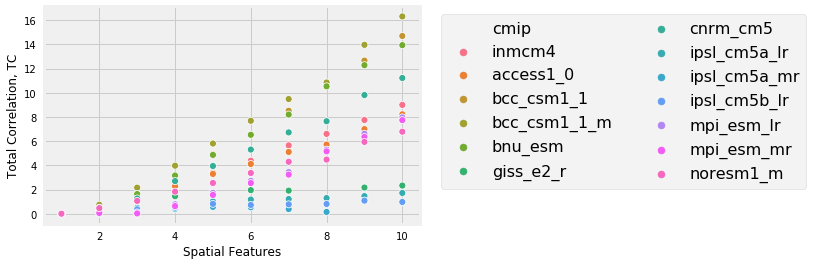

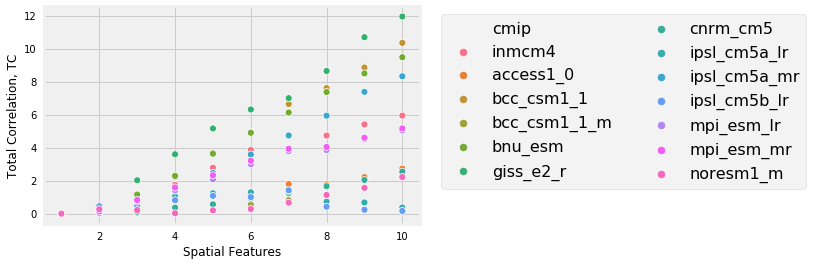

In [405]:
plot_global_diff_tc(results, 'era5', normalized=True)
plot_global_diff_tc(results, 'ncep', normalized=True)

### Mutual Information

In [406]:
results = pd.read_csv(results_path + 'compare_trial_v1' + '.csv', index_col=[0])
results.head()

,base,cmip,kendelltau,mi,pearson,spatial,spearman,subsample,time_mi,variable
0,ncep,inmcm4,0.552030,9.962479,0.833456,1.0,0.711300,10000.0,39.619016,psl
1,ncep,inmcm4,0.568794,1.489607,0.842241,2.0,0.730925,10000.0,10.354173,psl
2,ncep,inmcm4,0.581166,1.555495,0.844528,3.0,0.745527,10000.0,65.894330,psl
3,ncep,inmcm4,0.562111,1.463338,0.803643,4.0,0.715848,10000.0,96.675056,psl
4,ncep,inmcm4,0.529905,1.766060,0.751060,5.0,0.670227,10000.0,73.076941,psl


In [407]:
def plot_global_mi(results_df: pd.DataFrame, base: str, cmip: str, measure='mi', normalized=True)-> None:
    
    results_df = results_df[results_df['base'] == base]
    results_df = results_df[results_df['cmip'] == cmip]
    
    if normalized and measure == 'mi':
        results_df[measure] = results_df[measure] / results_df['spatial']
    sns.scatterplot(data=results_df, x='spatial', y=measure, label=f"{base}")
    sns.scatterplot(data=results_df, x='spatial', y=measure, label=f"{cmip}")
    plt.title(f'{base.upper()}, CMIP: {cmip.upper()}')
    plt.xlabel('Spatial Features')
    plt.ylabel('Mutual Information, MI')
    plt.legend()
    plt.show()

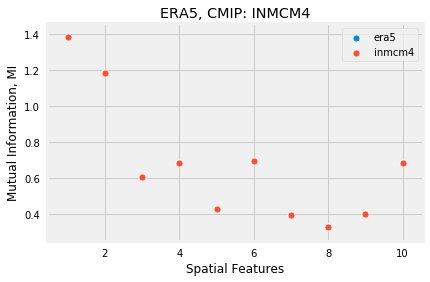

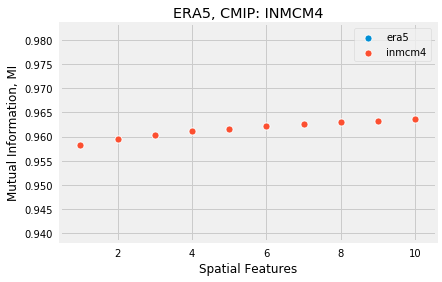

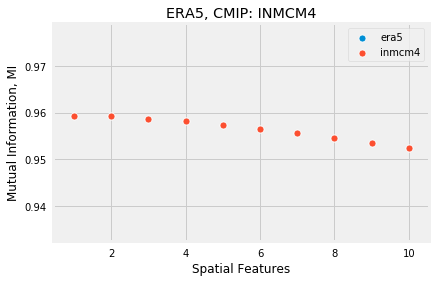

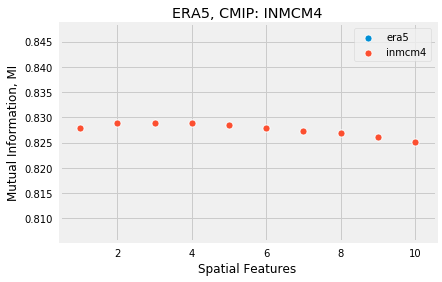

In [408]:
plot_global_mi(results, 'era5', 'inmcm4', 'mi')
plot_global_mi(results, 'era5', 'inmcm4', 'pearson')
plot_global_mi(results, 'era5', 'inmcm4', 'spearman')
plot_global_mi(results, 'era5', 'inmcm4', 'kendelltau')

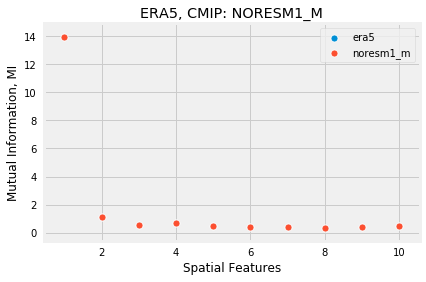

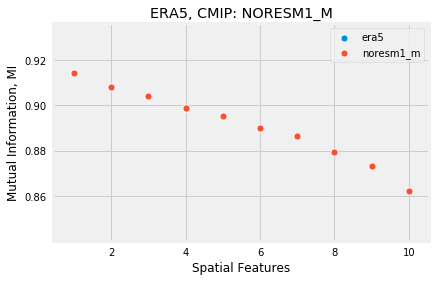

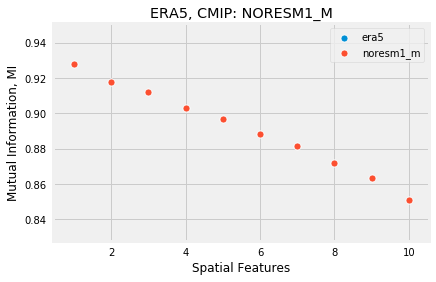

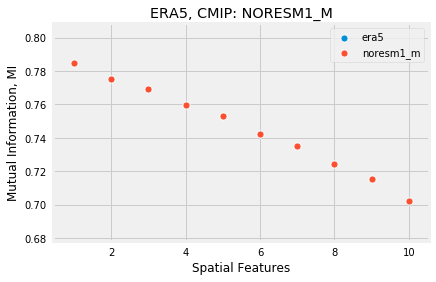

In [409]:
plot_global_mi(results, 'era5', 'noresm1_m', 'mi')
plot_global_mi(results, 'era5', 'noresm1_m', 'pearson')
plot_global_mi(results, 'era5', 'noresm1_m', 'spearman')
plot_global_mi(results, 'era5', 'noresm1_m', 'kendelltau')

In [410]:
def plot_global_diff_mi(results_df: pd.DataFrame, base: str, measure='mi', normalized=True, log_mi=True)-> None:
    
    
    results_copy = results_df[results_df['base'] == base]
    
        
    if normalized == True:
        results_copy[measure] = results_copy[measure] / results_copy['spatial']
    
    if log_mi == True and measure == 'mi':
        results_copy[measure] = np.log(results_copy[measure])
    
    fig, ax = plt.subplots()
#     sns.scatterplot(ax=ax, data=results_copy, x='spatial', y='h_diff', hue='base', color='black')
    sns.scatterplot(ax=ax, data=results_copy, x='spatial', y=measure, hue='cmip')
        
    plt.title(f'')
    plt.xlabel('Spatial Features')
    plt.ylabel(f'{measure.upper()}')
    plt.legend(ncol=2, bbox_to_anchor=(2.05, 1), fontsize=16)
#     plt.tight_layout()
    plt.show()

/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/emmanuel/.conda/envs/2019_rbig_ad/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


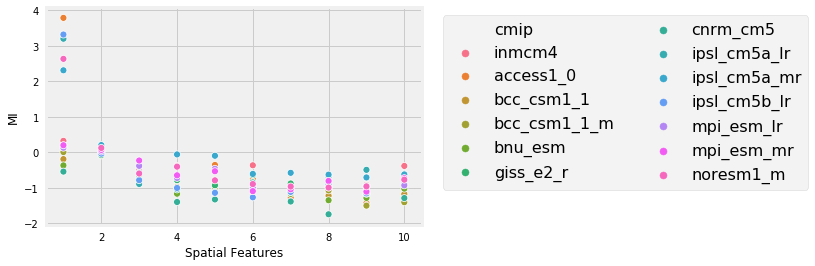

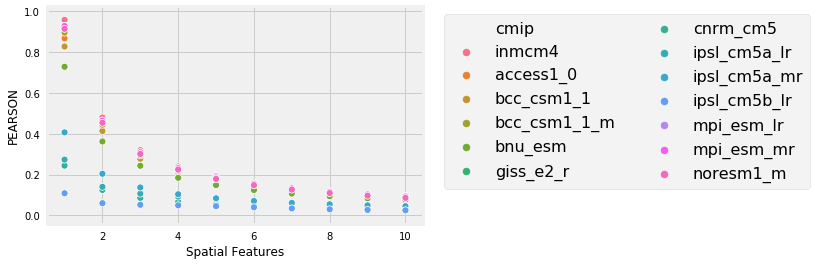

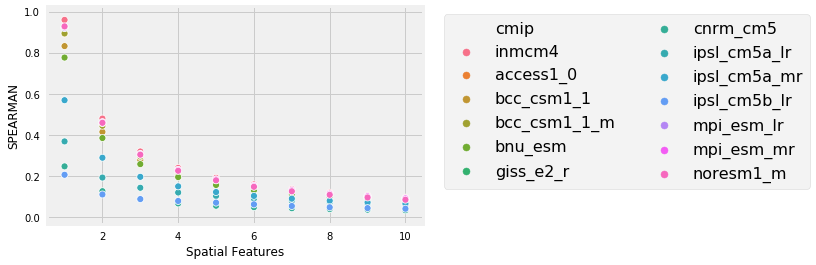

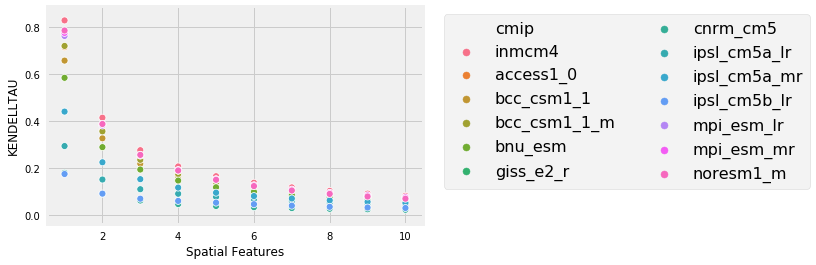

In [412]:
plot_global_diff_mi(results, 'era5', 'mi', True, True)
plot_global_diff_mi(results, 'era5', 'pearson', True, True)
plot_global_diff_mi(results, 'era5', 'spearman', True, True)
plot_global_diff_mi(results, 'era5', 'kendelltau', True, True)